In [1]:
%matplotlib inline

import numpy as np
import scipy.io as sio
import pandas as pd
import os
from scipy import stats
import pickle
import operator
from matplotlib.patches import Rectangle
import re
from ipywidgets import FloatProgress
from IPython.display import display
from ipywidgets import *
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import ElasticNetCV, SGDClassifier
from sklearn.preprocessing import RobustScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.svm import SVR, LinearSVC
from sklearn.feature_selection import RFECV
from sklearn import feature_selection
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import model_selection
from numpy.random import choice
import seaborn as sns
from scipy.stats import wilcoxon, mannwhitneyu, ks_2samp
from itertools import chain, combinations
from sklearn import linear_model
import os.path as op
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

### Utils

In [13]:
def build_matrices(roi_ids,subset,ids,path):
    msn_mats = np.zeros([len(roi_ids), len(roi_ids),len(ids)])
    i=0
    if len(subset)==1:
        for el in ids:
            fmat = stats.zscore(np.genfromtxt('{}{}_All_parameters_nospaces.csv'.format(path,el),delimiter=','),
                                axis=0,ddof=1)
            msn_mats[:,:,i] = squareform(pdist(fmat[np.ix_(roi_ids,subset)],'minkowski',p=1))
            i=i+1
        return msn_mats
    for el in ids:
        fmat = stats.zscore(np.genfromtxt('{}{}_All_parameters_nospaces.csv'.format(path,el),delimiter=','),
                            axis=0,ddof=1)
        msn_mats[:,:,i] = np.corrcoef(fmat[np.ix_(roi_ids,subset)])
        i=i+1
    return msn_mats

def roi_metrics(roi_ids,subset,ids,path):
    metrics = np.zeros([len(ids),len(roi_ids)*len(subset)])
    i=0
    for el in ids:
        fmat = stats.zscore(np.genfromtxt('{}{}_All_parameters_nospaces.csv'.format(path,el),delimiter=','),
                            axis=0,ddof=1)
        metrics[i,:] = fmat[np.ix_(roi_ids,subset)].reshape(-1)
        i=i+1
    return metrics

def predict_loo(matrices,score,model='elnet',doFilter=False, filterThr=0.01, confounds=None):
    n_parcels = matrices.shape[0]
    triu_idx = np.triu_indices(n_parcels,1)
    n_edges = len(triu_idx[1])
    n_subj = matrices.shape[-1]
    edges = np.zeros([n_subj,n_edges])
    for subject in range(matrices.shape[-1]):
        edges[subject,] = matrices[:,:,subject][triu_idx]
    if not confounds is None:
        print('Adding', confounds.shape[-1],'confounds...')
        edges = np.hstack([edges, confounds])
        n_edges = n_edges+confounds.shape[-1]
    loo = model_selection.LeaveOneOut()
    # Test with all edges and parameter selection by cross validation
    k=3 # no. of splits for cross-validation
    errors = np.zeros([n_subj,1])
    predictions = np.zeros([n_subj,1])
    fscores = np.zeros([n_edges,n_subj])
    params = np.zeros([n_subj,1])
    folds = list()
    i=0
    for train_index, test_index in loo.split(edges):
        folds.append([train_index, test_index])
        if doFilter:
            pears  = [stats.pearsonr(np.squeeze(edges[train_index,j]),score[train_index]) for j in range(0,n_edges)]
            idx_filtered = np.array([idx for idx in range(n_edges) if pears[idx][1]<filterThr])
            if len(idx_filtered) == 0:
                idx_filtered = np.arange(n_edges) 
                print('WARNING: no features found after filter, using all features')
        else:
            idx_filtered = np.arange(n_edges)
        X_train, X_test, y_train, y_test = edges[np.ix_(train_index,idx_filtered)], edges[np.ix_(test_index,idx_filtered)],score[train_index],score[test_index]
        rbX = RobustScaler()
        X_train = rbX.fit_transform(X_train)
        X_test = rbX.transform(X_test)
        hist_cv, bin_limits_cv = np.histogram(y_train, bins=np.percentile(score,[0,25,50,75,100]))
        bins_cv = np.digitize(y_train, bin_limits_cv[:-1])
        cv = model_selection.StratifiedKFold(n_splits=k)
        if model=='elnet':
            elnet = ElasticNetCV(l1_ratio=[.01, .05, .1, .9, .95, .99],cv=cv.split(X_train, bins_cv),n_jobs=-1,max_iter=12000)
            elnet.fit(X_train,y_train)
            predictions[i] = elnet.predict(X_test)
            errors[i] = predictions[i]-score[test_index]
            fscores[idx_filtered,i] = elnet.coef_
            params[i] = elnet.l1_ratio_
        if model=='svr':
            svr = SVR(kernel='linear', epsilon=0.01)
            selector = RFECV(svr, step=round(0.10*edges.shape[1]), cv=4) #4-fold NOT stratified
            param_grid = [{'estimator__C': [val for val in np.logspace(-6,0,10)]}]
            grids = GridSearchCV(selector, param_grid, cv = model_selection.StratifiedKFold(n_splits=k).split(X_train, bins_cv))
            grids.fit(X_train,y_train)
            predictions[i] = grids.predict(X_test)
            errors[i] = predictions[i]-score[test_index]
            fscores[idx_filtered,i] = grids.best_estimator_.support_
            params[i] = grids.best_estimator_.estimator_.C
        if model=='RF':
            rf = RandomForestRegressor(random_state=42, n_estimators=200, oob_score=True, 
                                        min_samples_split=3, n_jobs=-1, criterion='mae')
            rf.fit(X_train,y_train)
            predictions[i] = rf.predict(X_test)
            errors[i] = predictions[i]-score[test_index]
            fscores[idx_filtered,i] = rf.feature_importances_
            params[i] = rf.oob_score_ 
        i=i+1
    
    return (predictions, errors, folds, fscores, params, idx_filtered) 

def predict_metrics_loo(metrics,score,model='elnet',doFilter=False, filterThr=0.01, confounds=None):
    n_edges = metrics.shape[1]
    n_subj = metrics.shape[0]
    if not confounds is None:
        print('Adding', confounds.shape[-1],'confounds...')
        edges = np.hstack([metrics, confounds])
        n_edges = n_edges+confounds.shape[-1]
    loo = model_selection.LeaveOneOut()
    # Test with all edges and parameter selection by cross validation
    k=3 # no. of splits for cross-validation
    errors = np.zeros([n_subj,1])
    predictions = np.zeros([n_subj,1])
    fscores = np.zeros([n_edges,n_subj])
    params = np.zeros([n_subj,1])
    folds = list()
    i=0
    for train_index, test_index in loo.split(edges):
        folds.append([train_index, test_index])
        if doFilter:
            pears  = [stats.pearsonr(np.squeeze(edges[train_index,j]),score[train_index]) for j in range(0,n_edges)]
            idx_filtered = np.array([idx for idx in range(n_edges) if pears[idx][1]<filterThr])
            if len(idx_filtered) == 0:
                idx_filtered = np.arange(n_edges) 
                print('WARNING: no features found after filter, using all features')
        else:
            idx_filtered = np.arange(n_edges)
        X_train, X_test, y_train, y_test = edges[np.ix_(train_index,idx_filtered)], edges[np.ix_(test_index,idx_filtered)],score[train_index],score[test_index]
        rbX = RobustScaler()
        X_train = rbX.fit_transform(X_train)
        X_test = rbX.transform(X_test)
        hist_cv, bin_limits_cv = np.histogram(y_train, bins=np.percentile(score,[0,25,50,75,100]))
        bins_cv = np.digitize(y_train, bin_limits_cv[:-1])
        cv = model_selection.StratifiedKFold(n_splits=k)
        if model=='elnet':
            elnet = ElasticNetCV(l1_ratio=[.01, .05, .1, .9, .95, .99],cv=cv.split(X_train, bins_cv),n_jobs=-1,max_iter=12000)
            elnet.fit(X_train,y_train)
            predictions[i] = elnet.predict(X_test)
            errors[i] = predictions[i]-score[test_index]
            fscores[idx_filtered,i] = elnet.coef_
            params[i] = elnet.l1_ratio_
        i=i+1
    
    return (predictions, errors, folds, fscores, params, idx_filtered) 

def predict_dc_loo(matrices,score,model='elnet',doFilter=False, filterThr=0.01, confounds=None):
    n_parcels = matrices.shape[0]
    triu_idx = np.triu_indices(n_parcels,1)
    n_edges = len(triu_idx[1])
    n_subj = matrices.shape[-1]
    edges = np.zeros([n_subj,n_edges])
    for subject in range(matrices.shape[-1]):
        edges[subject,] = matrices[:,:,subject][triu_idx]

    loo = model_selection.LeaveOneOut()
    # Test with all edges and parameter selection by cross validation
    k=3 # no. of splits for cross-validation
    errors = np.zeros([n_subj,1])
    predictions = np.zeros([n_subj,1])
    fscores = np.zeros([n_edges,n_subj])
    params = np.zeros([n_subj,1])
    folds = list()
    i=0
    for train_index, test_index in loo.split(edges):
        folds.append([train_index, test_index])
        if doFilter:
            if not confounds is None:
                pears  = pcorr(edges[train_index,:],score[train_index],confounds[train_index,:])
                idx_filtered = np.array([idx for idx in range(n_edges) if pears[idx][1]<filterThr])
                if len(idx_filtered) == 0:
                    idx_filtered = np.arange(n_edges) 
                    print('WARNING: no features found after filter, using all features')
            else:
                pears  = [stats.pearsonr(np.squeeze(edges[train_index,j]),score[train_index]) for j in range(0,n_edges)]
                idx_filtered = np.array([idx for idx in range(n_edges) if pears[idx][1]<filterThr])
                if len(idx_filtered) == 0:
                    idx_filtered = np.arange(n_edges) 
                    print('WARNING: no features found after filter, using all features')
        else:
            idx_filtered = np.arange(n_edges)
        X_train, X_test, y_train, y_test = edges[np.ix_(train_index,idx_filtered)], edges[np.ix_(test_index,idx_filtered)],score[train_index],score[test_index]
        rbX = RobustScaler()
        X_train = rbX.fit_transform(X_train)
        X_test = rbX.transform(X_test)
        hist_cv, bin_limits_cv = np.histogram(y_train, bins=np.percentile(score,[0,25,50,75,100]))
        bins_cv = np.digitize(y_train, bin_limits_cv[:-1])
        cv = model_selection.StratifiedKFold(n_splits=k)
        if model=='elnet':
            elnet = ElasticNetCV(l1_ratio=[.01, .05, .1, .9, .95, .99],cv=cv.split(X_train, bins_cv),n_jobs=-1,max_iter=12000)
            elnet.fit(X_train,y_train)
            predictions[i] = elnet.predict(X_test)
            errors[i] = predictions[i]-score[test_index]
            fscores[idx_filtered,i] = elnet.coef_
            params[i] = elnet.l1_ratio_
        if model=='svr':
            svr = SVR(kernel='linear', epsilon=0.01)
            selector = RFECV(svr, step=round(0.10*edges.shape[1]), cv=4) #4-fold NOT stratified
            param_grid = [{'estimator__C': [val for val in np.logspace(-6,0,10)]}]
            grids = GridSearchCV(selector, param_grid, cv = model_selection.StratifiedKFold(n_splits=k).split(X_train, bins_cv))
            grids.fit(X_train,y_train)
            predictions[i] = grids.predict(X_test)
            errors[i] = predictions[i]-score[test_index]
            fscores[idx_filtered,i] = grids.best_estimator_.support_
            params[i] = grids.best_estimator_.estimator_.C
        if model=='RF':
            rf = RandomForestRegressor(random_state=42, n_estimators=200, oob_score=True, 
                                        min_samples_split=3, n_jobs=-1, criterion='mae')
            rf.fit(X_train,y_train)
            predictions[i] = rf.predict(X_test)
            errors[i] = predictions[i]-score[test_index]
            fscores[idx_filtered,i] = rf.feature_importances_
            params[i] = rf.oob_score_ 
        i=i+1
    
    return (predictions, errors, folds, fscores, params, idx_filtered)

def predict_cr_loo(matrices,score,model='elnet',doFilter=False, filterThr=0.01, confounds=None):
    n_parcels = matrices.shape[0]
    triu_idx = np.triu_indices(n_parcels,1)
    n_edges = len(triu_idx[1])
    n_subj = matrices.shape[-1]
    edges = np.zeros([n_subj,n_edges])
    for subject in range(matrices.shape[-1]):
        edges[subject,] = matrices[:,:,subject][triu_idx]

    loo = model_selection.LeaveOneOut()
    # Test with all edges and parameter selection by cross validation
    k=3 # no. of splits for cross-validation
    errors = np.zeros([n_subj,1])
    predictions = np.zeros([n_subj,1])
    fscores = np.zeros([n_edges,n_subj])
    params = np.zeros([n_subj,1])
    folds = list()
    i=0
    for train_index, test_index in loo.split(edges):
        folds.append([train_index, test_index])
        if not confounds is None:
            n = edges.shape[1]
            X  = np.concatenate((np.ones([len(train_index),1]), confounds[train_index,:]), axis=1)
            regr = linear_model.LinearRegression()
            regr.fit(confounds[train_index,:],edges[train_index,:])
            fitted_values = regr.predict(confounds)
            edges_dc = edges - fitted_values
        else:
            edges_dc = edges
        if doFilter:
            pears  = [stats.pearsonr(np.squeeze(edges_dc[train_index,j]),score[train_index]) for j in range(0,n_edges)]
            idx_filtered = np.array([idx for idx in range(n_edges) if pears[idx][1]<filterThr])
            if len(idx_filtered) == 0:
                idx_filtered = np.arange(n_edges) 
                print('WARNING: no features found after filter, using all features')
        else:
            idx_filtered = np.arange(n_edges)
        X_train, X_test, y_train, y_test = edges_dc[np.ix_(train_index,idx_filtered)], edges_dc[np.ix_(test_index,idx_filtered)],score[train_index],score[test_index]
        rbX = RobustScaler()
        X_train = rbX.fit_transform(X_train)
        X_test = rbX.transform(X_test)
        hist_cv, bin_limits_cv = np.histogram(y_train, bins=np.percentile(score,[0,25,50,75,100]))
        bins_cv = np.digitize(y_train, bin_limits_cv[:-1])
        cv = model_selection.StratifiedKFold(n_splits=k)
        if model=='elnet':
            elnet = ElasticNetCV(l1_ratio=[.01, .05, .1, .9, .95, .99],cv=cv.split(X_train, bins_cv),n_jobs=-1,max_iter=12000)
            elnet.fit(X_train,y_train)
            predictions[i] = elnet.predict(X_test)
            errors[i] = predictions[i]-score[test_index]
            fscores[idx_filtered,i] = elnet.coef_
            params[i] = elnet.l1_ratio_
        if model=='svr':
            svr = SVR(kernel='linear', epsilon=0.01)
            selector = RFECV(svr, step=round(0.10*edges.shape[1]), cv=4) #4-fold NOT stratified
            param_grid = [{'estimator__C': [val for val in np.logspace(-6,0,10)]}]
            grids = GridSearchCV(selector, param_grid, cv = model_selection.StratifiedKFold(n_splits=k).split(X_train, bins_cv))
            grids.fit(X_train,y_train)
            predictions[i] = grids.predict(X_test)
            errors[i] = predictions[i]-score[test_index]
            fscores[idx_filtered,i] = grids.best_estimator_.support_
            params[i] = grids.best_estimator_.estimator_.C
        if model=='RF':
            rf = RandomForestRegressor(random_state=42, n_estimators=200, oob_score=True, 
                                        min_samples_split=3, n_jobs=-1, criterion='mae')
            rf.fit(X_train,y_train)
            predictions[i] = rf.predict(X_test)
            errors[i] = predictions[i]-score[test_index]
            fscores[idx_filtered,i] = rf.feature_importances_
            params[i] = rf.oob_score_ 
        i=i+1
    
    return (predictions, errors, folds, fscores, params, idx_filtered)

def pcorr(X,y,z):
    """
    Returns the sample linear partial correlation coefficients between each column in X and variable y, controlling 
    for the variable z.
    Parameters
    ----------
    X : array-like, shape (n, p)
        Array with the different variables. Each column of X is taken as a variable
    Returns
    -------
    P : array-like, shape (p,)
        P[i,0] contains the partial correlation of X[:, i] and y controlling
        for z and P[i,1] the associated p-value.
    """
    p = X.shape[1]
    P_corr = np.zeros((p,2), dtype=np.float)
    for i in range(p):
        fit1 = linear_model.LinearRegression(fit_intercept=True)
        fit2 = linear_model.LinearRegression(fit_intercept=True)
        fit1.fit(z, X[:,i])
        fit2.fit(z, y)
        residual1 = X[:,i] - (np.dot(z, fit1.coef_) + fit1.intercept_)
        residual2 = y - (np.dot(z, fit2.coef_) + fit2.intercept_)
        P_corr[i,] = stats.pearsonr(residual1, residual2)
        
    return P_corr


def predict_kfold(matrices,score,model='elnet',doFilter=False, filterThr=0.01,n_splits=5, n_repeats=10, confounds=None):
    n_parcels = matrices.shape[0]
    triu_idx = np.triu_indices(n_parcels,1)
    n_edges = len(triu_idx[1])
    n_subj = matrices.shape[-1]
    edges = np.zeros([n_subj,n_edges])
    for subject in range(matrices.shape[-1]):
        edges[subject,] = matrices[:,:,subject][triu_idx]
    if not confounds is None:
        print('Adding', confounds.shape[-1],'confounds...')
        edges = np.hstack([edges, confounds])
        n_edges = n_edges+confounds.shape[-1]
    kfold = model_selection.RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    # Test with all edges and parameter selection by cross validation
    k=3 # no. of splits for cross-validation
    errors = list()
    predictions = list()
    fscores = list()
    params = list()
    folds = list()
    hist_cv, bin_limits_cv = np.histogram(score, bins=np.percentile(score,[0,25,50,75,100]))
    bins_cv = np.digitize(score, bin_limits_cv[:-1])
    i=0
    for train_index, test_index in kfold.split(edges,bins_cv):
        folds.append([train_index, test_index])
        if doFilter:
            pears  = [stats.pearsonr(np.squeeze(edges[train_index,j]),score[train_index]) for j in range(0,n_edges)]
            idx_filtered = np.array([idx for idx in range(n_edges) if pears[idx][1]<filterThr])
        else:
            idx_filtered = np.arange(n_edges)
        X_train, X_test, y_train, y_test = edges[np.ix_(train_index,idx_filtered)], edges[np.ix_(test_index,idx_filtered)],score[train_index],score[test_index]
        rbX = RobustScaler()
        X_train = rbX.fit_transform(X_train)
        X_test = rbX.transform(X_test)
        hist_cv, bin_limits_cv = np.histogram(y_train, bins=np.percentile(score,[0,25,50,75,100]))
        bins_cv = np.digitize(y_train, bin_limits_cv[:-1])
        cv = model_selection.StratifiedKFold(n_splits=k)
        if model=='elnet':
            elnet = ElasticNetCV(l1_ratio=[.01, .05, .1, .9, .95, .99],cv=cv.split(X_train, bins_cv),n_jobs=-1,max_iter=12000)
            elnet.fit(X_train,y_train)
            predictions.append(elnet.predict(X_test))
            errors.append(predictions[i]-score[test_index])
            fscores.append(elnet.coef_)
            params.append(elnet.l1_ratio_)
        if model=='svr':
            svr = SVR(kernel='linear', epsilon=0.01)
            selector = RFECV(svr, step=round(0.10*edges.shape[1]), cv=4) #4-fold NOT stratified
            param_grid = [{'estimator__C': [val for val in np.logspace(-6,0,10)]}]
            grids = GridSearchCV(selector, param_grid, cv = model_selection.StratifiedKFold(n_splits=k).split(X_train, bins_cv))
            grids.fit(X_train,y_train)
            predictions.append(grids.predict(X_test))
            errors.append(predictions[i]-score[test_index])
            fscores.append(grids.best_estimator_.support_)
            params.append(grids.best_estimator_.estimator_.C)
        if model=='RF':
            rf = RandomForestRegressor(random_state=42, n_estimators=200, oob_score=True, 
                                        min_samples_split=3, n_jobs=-1, criterion='mae')
            rf.fit(X_train,y_train)
            predictions.append(rf.predict(X_test))
            errors.append(predictions[i]-score[test_index])
            fscores.append(rf.feature_importances_)
            params.append(rf.oob_score_)
        i=i+1
    
    return (predictions, errors, folds, fscores, params, idx_filtered) 


def predict_shuffle(matrices,score,labels,model='elnet',doFilter=False, filterThr=0.01,n_splits=10, test_size=0.1, confounds=None):
    n_parcels = matrices.shape[0]
    triu_idx = np.triu_indices(n_parcels,1)
    n_edges = len(triu_idx[1])
    n_subj = matrices.shape[-1]
    edges = np.zeros([n_subj,n_edges])
    for subject in range(matrices.shape[-1]):
        edges[subject,] = matrices[:,:,subject][triu_idx]
    if not confounds is None:
        print('Adding', confounds.shape[-1],'confounds...')
        edges = np.hstack([edges, confounds])
        n_edges = n_edges+confounds.shape[-1]
    cvmodel = model_selection.StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)
    # Test with all edges and parameter selection by cross validation
    k=3 # no. of splits for cross-validation
    errors = list()
    predictions = list()
    fscores = list()
    params = list()
    folds = list()
    i=0
    for train_index, test_index in cvmodel.split(edges,labels):
        folds.append([train_index, test_index])
        if doFilter:
            pears  = [stats.pearsonr(np.squeeze(edges[train_index,j]),score[train_index]) for j in range(0,n_edges)]
            idx_filtered = np.array([idx for idx in range(n_edges) if pears[idx][1]<filterThr])
        else:
            idx_filtered = np.arange(n_edges)

        edges_dc = edges
        X_train, X_test, y_train, y_test = edges_dc[np.ix_(train_index,idx_filtered)], edges_dc[np.ix_(test_index,idx_filtered)],score[train_index],score[test_index]
        rbX = RobustScaler()
        X_train = rbX.fit_transform(X_train)
        X_test = rbX.transform(X_test)
        hist_cv, bin_limits_cv = np.histogram(y_train, bins=np.percentile(score,[0,25,50,75,100]))
        bins_cv = np.digitize(y_train, bin_limits_cv[:-1])
        cv = model_selection.StratifiedKFold(n_splits=k)
        if model=='elnet':
            elnet = ElasticNetCV(l1_ratio=[.01, .05, .1, .9, .95, .99],cv=cv.split(X_train, bins_cv),n_jobs=-1,max_iter=12000)
            elnet.fit(X_train,y_train)
            predictions.append(elnet.predict(X_test))
            errors.append(predictions[i]-score[test_index])
            fscores.append(elnet.coef_)
            params.append(elnet.l1_ratio_)
        if model=='svr':
            svr = SVR(kernel='linear', epsilon=0.01)
            selector = RFECV(svr, step=round(0.10*edges.shape[1]), cv=4) #4-fold NOT stratified
            param_grid = [{'estimator__C': [val for val in np.logspace(-6,0,10)]}]
            grids = GridSearchCV(selector, param_grid, cv = model_selection.StratifiedKFold(n_splits=k).split(X_train, bins_cv))
            grids.fit(X_train,y_train)
            predictions.append(grids.predict(X_test))
            errors.append(predictions[i]-score[test_index])
            fscores.append(grids.best_estimator_.support_)
            params.append(grids.best_estimator_.estimator_.C)
        if model=='RF':
            rf = RandomForestRegressor(random_state=42, n_estimators=200, oob_score=True, 
                                        min_samples_split=3, n_jobs=-1, criterion='mae')
            rf.fit(X_train,y_train)
            predictions.append(rf.predict(X_test))
            errors.append(predictions[i]-score[test_index])
            fscores.append(rf.feature_importances_)
            params.append(rf.oob_score_)
        i=i+1
    
    return (predictions, errors, folds, fscores, params, idx_filtered) 

def predict_MC(matrices, score, term_ids, preterm_ids, model='elnet', runs=100, doFilter=False, filterThr=0.01,
              n_term_train = 50, n_preterm_test=15):
    
    n_test = n_preterm_test + len(term_ids) - n_term_train
    n_parcels = matrices.shape[0]
    triu_idx = np.triu_indices(n_parcels,1)
    n_edges = len(triu_idx[1])
    n_subj = matrices.shape[-1]
    edges = np.zeros([n_subj,n_edges])
    for subject in range(matrices.shape[-1]):
        edges[subject,] = matrices[:,:,subject][triu_idx]
    errors = np.zeros([runs,n_test])
    predictions = np.zeros([runs,n_test])
    fscores = np.zeros([n_edges,runs])
    params = np.zeros([runs,1])
    folds = list()
    k=3 # no. of splits for cross-validation
    for i in range(runs):
        train_ids = choice(term_ids,(n_term_train,),replace=False)
        test_ids = np.hstack([choice(preterm_ids,(n_preterm_test,),replace=False),np.setdiff1d(term_ids,train_ids)])
        folds.append((train_ids, test_ids))
    i=0
    for train_index, test_index in folds:
        if doFilter:
            pears  = [stats.pearsonr(np.squeeze(edges[train_index,j]),score[train_index]) for j in range(0,n_edges)]
            idx_filtered = np.array([idx for idx in range(n_edges) if pears[idx][1]<filterThr])
        else:
            idx_filtered = np.arange(n_edges)
        X_train, X_test, y_train, y_test = edges[np.ix_(train_index,idx_filtered)], edges[np.ix_(test_index,idx_filtered)],score[train_index],score[test_index]
        rbX = RobustScaler()
        X_train = rbX.fit_transform(X_train)
        X_test = rbX.transform(X_test)
        hist_cv, bin_limits_cv = np.histogram(y_train, bins=np.percentile(score,[0,50,100]))
        bins_cv = np.digitize(y_train, bin_limits_cv[:-1])
        cv = model_selection.StratifiedKFold(n_splits=k)
        if model=='elnet':
            elnet = ElasticNetCV(l1_ratio=[.01, .05, .1, .9, .95, .99],cv=cv.split(X_train, bins_cv),n_jobs=-1,max_iter=12000)
            elnet.fit(X_train,y_train)
            predictions[i,:] = elnet.predict(X_test)
            errors[i,:] = predictions[i]-score[test_index]
            fscores[idx_filtered,i] = elnet.coef_
            params[i] = elnet.l1_ratio_
        if model=='svr':
            svr = SVR(kernel='linear', epsilon=0.01)
            selector = RFECV(svr, step=round(0.10*edges.shape[1]), cv=4) #4-fold NOT stratified
            param_grid = [{'estimator__C': [val for val in np.logspace(-6,0,10)]}]
            grids = GridSearchCV(selector, param_grid, cv = model_selection.StratifiedKFold(n_splits=k).split(X_train, bins_cv))
            grids.fit(X_train,y_train)
            predictions[i,:] = grids.predict(X_test)
            errors[i,:] = predictions[i]-score[test_index]
            fscores[idx_filtered,i] = grids.best_estimator_.support_
            params[i] = grids.best_estimator_.estimator_.C
        if model=='RF':
            rf = RandomForestRegressor(random_state=42, n_estimators=200, oob_score=True, 
                                        min_samples_split=3, n_jobs=-1, criterion='mae')
            rf.fit(X_train,y_train)
            predictions[i,:] = rf.predict(X_test)
            errors[i,:] = predictions[i]-score[test_index]
            fscores[idx_filtered,i] = rf.feature_importances_
            params[i] = rf.oob_score_ 
        i=i+1
    
    return (predictions, errors, folds, fscores, params) 


def select_edges(n_rois, fscores, model, th=.5):
    edges = np.zeros([n_rois,n_rois])
    triu_idx = np.triu_indices(n_rois,1)
    n_models = fscores.shape[1]
    if model=='elnet':
        for i in range(n_models):
            edges[triu_idx] += (fscores[:,i]!=0).astype(int)
        edges = edges / n_models  
    if model=='RF':
        for i in range(n_models):
            edges[triu_idx] += (fscores[:,i]>np.percentile(fscores[:,i],75)).astype(int)
        edges = edges / n_models 
    if model=='svr':
        for i in range(n_models):
            edges[triu_idx] += (fscores[:,i]).astype(int)
        edges = edges / n_models 
    idx = np.where(edges>th)    
    return idx

def intersect_edges(edges1, edges2):
    edges1_ = [(edges1[0][i],edges1[1][i]) for i in range(len(edges1[0]))]
    edges2_ = [(edges2[0][i],edges2[1][i]) for i in range(len(edges2[0]))]
    intersection = [el for el in edges1_ if (el in edges1_ and el in edges2_)]
    return [el[0] for el in intersection], [el[1] for el in intersection]

def diff_edges(edges1, edges2):
    edges1_ = [(edges1[0][i],edges1[1][i]) for i in range(len(edges1[0]))]
    edges2_ = [(edges2[0][i],edges2[1][i]) for i in range(len(edges2[0]))]
    intersection = [el for el in edges1_ if (el in edges1_ and el not in edges2_)]
    return [el[0] for el in intersection], [el[1] for el in intersection]

def fsubset(fnames):
    return [col_idx[x] for x in fnames]

def save_results(path,code,score,predictions,errs,folds,fscores,params,roi_ids,features,subjects,model,doFilter,cv):
    results = {'preds': predictions, 
               'errs': errs, 
               'folds': folds, 
               'params': params, 
               'rois': roi_ids,
               'features': features,
               'score': score, 
               'fscores':fscores
              }
    sio.savemat('{}{}_{}_{}_{}.mat'.format(path, model, 'filter' if doFilter else 'nofilter', cv, code), results)

### Declare parameters

In [4]:
datapath = 'data/'
#volume T1/T2 FA MD AD RD KURT NDI(ICVF) ISO ODItot ODIp ODIs
features_all = np.array([
            'Volume', #
            'T1/T2',  #
            'FA',     # fractional anisotropy
            'MD',     # mean diffusivity
            'AD',     # axial diffusivity
            'RD',     # radial diffusivity
            'KURT',   # kurtosis
            'ICVF',   # intra-cellular volume fraction
            'ISO',    # isotropic water volume (CSF)
            'ODItot', # orientation dispersion index (total)
            'ODIp',   # orientation dispersion index (p-axis)
            'ODIs',   # orientation dispersion index (s-axis)
])

best_loo = np.array(['T1/T2', 'FA', 'KURT', 'ISO'])
best_exs = np.array(['Volume', 'T1/T2', 'FA', 'KURT', 'ICVF', 'ISO'])
best_all_dc = ['Volume', 'FA', 'MD', 'AD', 'KURT', 'ISO', 'ODIp']



# match feature with column index in CSV file
col_idx = {
        'Volume':0,   #
        'T1/T2' :1,   #
        'FA'    :2,   # fractional anisotropy
        'MD'    :3,   # mean diffusivity
        'AD'    :4,   # axial diffusivity
        'RD'    :5,   # radial diffusivity
        'KURT'  :6,   # kurtosis
        'ICVF'  :7,   # intra-cellular volume fraction
        'ISO'   :8,   # isotropic water volume (CSF)
        'ODItot':9,   # orientation dispersion index (total)
        'ODIp'  :10,  # orientation dispersion index (p-axis)
        'ODIs'  :11,  # orientation dispersion index (s-axis)
}

roi_labels = np.array(pd.read_csv(datapath+'labels.txt',sep='\t', header=None, usecols=[1]))
csf_ids = np.array([49, 50, 83, 84, 85])-1
cc_id = [47]
roi_toremove = np.union1d(csf_ids, cc_id)
wmgm_ids = np.setdiff1d(np.arange(len(roi_labels)),roi_toremove)
wmgm_labels = roi_labels[wmgm_ids]
wmgm_left = np.array([wmgm_ids[i] for i in range(len(wmgm_ids)) if 'left' in wmgm_labels[i][0]])
wmgm_right = np.array([wmgm_ids[i] for i in range(len(wmgm_ids)) if 'right' in wmgm_labels[i][0]])
wmgm_left_labels = roi_labels[wmgm_left]
wmgm_right_labels = roi_labels[wmgm_right]

# TEBC data
demo = pd.read_csv(datapath+'final_parameters/demo.csv')
ids = np.array(demo['ID'])
GA_all = np.array(demo['exact GAS'])
BA_all = np.array(demo['GA birth'])

term_ids = demo.index[demo['Premature (1/0)']==0]
preterm_ids = demo.index[demo['Premature (1/0)']==1]
labels = np.array(demo['Premature (1/0)']) # 1->PRETERM, 0->TERM

gender = np.array(demo['Gender (M/F)']=='m').astype(int) # 1->M, 0->F
male_ids = demo.index[demo['Gender (M/F)']=='m']
female_ids = demo.index[demo['Gender (M/F)']=='f']

print('All: {} subjects ({} M), {} preterm ({} M), {} term ({} M)'.
      format(len(labels),len(male_ids),len(preterm_ids),
             len(np.intersect1d(preterm_ids,male_ids)),len(term_ids),len(np.intersect1d(term_ids,male_ids))))

All: 105 subjects (55 M), 59 preterm (29 M), 46 term (26 M)


### GA distribution (all data)

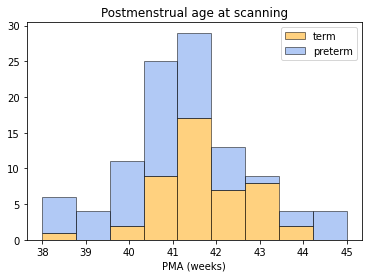

In [5]:
bins = np.linspace(38, 45, 10)
plt.title('Postmenstrual age at scanning')
plt.hist((GA_all[term_ids],GA_all[preterm_ids]),bins,alpha=0.5,stacked=True,edgecolor='black', linewidth=1,color=('orange','cornflowerblue'))
plt.legend(['term', 'preterm'])
plt.xlabel('PMA (weeks)')
plt.show()

In [440]:
np.mean(GA_all[term_ids]), np.std(GA_all[term_ids]), np.mean(GA_all[preterm_ids]), np.std(GA_all[preterm_ids])

(41.65652173913043, 1.0781248161009132, 40.993220338983065, 1.5632413529976485)

In [443]:
np.mean(GA_all), np.std(GA_all), 

(41.28380952380952, 1.410910129062177)

### BA distribution (all data)

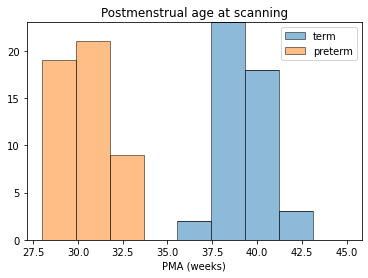

In [6]:
bins = np.linspace(28, 45, 10)
plt.title('Postmenstrual age at scanning')
plt.hist((BA_all[term_ids],BA_all[preterm_ids]),bins,alpha=0.5,stacked=True,edgecolor='black', linewidth=1)
plt.legend(['term', 'preterm'])
plt.xlabel('PMA (weeks)')
plt.show()

In [441]:
np.mean(BA_all[term_ids]), np.std(BA_all[term_ids]), np.mean(BA_all[preterm_ids]), np.std(BA_all[preterm_ids])

(39.318695652173915, 1.0756143011152766, 29.61864406779661, 1.8496023004750064)

In [442]:
np.mean(BA_all), np.std(BA_all), 

(33.86819047619048, 5.05878637449403)

In [142]:
stats.pearsonr(BA_all,GA_all)

(0.2729478125194327, 0.004845901752109297)

In [771]:
np.median(GA_all[male_ids]), np.median(GA_all[female_ids])

(41.14, 41.42)

In [773]:
stats.pearsonr(BA_all,gender)

(0.04753199020697929, 0.6301612161368847)

In [141]:
stats.pearsonr(GA_all,gender)

(-0.2212434121019501, 0.02332205770031045)

Gender distribution

In [7]:
sns.set_context('notebook')

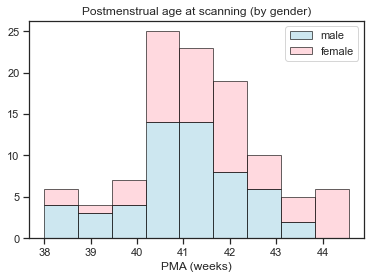

In [9]:
sns.set_style('ticks')
plt.title('Postmenstrual age at scanning (by gender)')
plt.hist((GA_all[male_ids],GA_all[female_ids]), bins=9,alpha=0.6,stacked=True,edgecolor='black', linewidth=1,color=('lightblue','pink'))
plt.legend(['male', 'female'])
plt.xlabel('PMA (weeks)')
plt.show()

In [10]:
sns.set_style('ticks')
plt.title('Postmenstrual age at birth (by gender)')
plt.hist((BA_all[male_ids],BA_all[female_ids]), bins=9,alpha=0.6,stacked=True,edgecolor='black', linewidth=1,color=('lightblue','pink'))
plt.legend(['male', 'female'])
plt.xlabel('age (weeks)')
plt.show()

## MSN construction

In [14]:
msn_mats_WMGM = build_matrices(wmgm_ids,[col_idx[x] for x in best_loo],ids,datapath+'final_parameters/')

# build matrix n_subjects x n_edges
n_parcels_WMGM = msn_mats_WMGM.shape[0]
triu_idx_WMGM = np.triu_indices(n_parcels_WMGM,1)
n_edges_WMGM = len(triu_idx_WMGM[1])
n_subj = len(ids)

def plt_conn(subject):
    plt.imshow(msn_mats_WMGM[:,:,subject-1], cmap='Spectral')
    plt.colorbar()
    plt.title('Connectivity matrix for subject '+str(ids[subject-1]))

interact(plt_conn, subject=(1,n_subj),continuous_update=False)    
    
edges_WMGM = np.zeros([n_subj,n_edges_WMGM])

for subject in range(msn_mats_WMGM.shape[-1]):
    edges_WMGM[subject,] = msn_mats_WMGM[:,:,subject][triu_idx_WMGM]

interactive(children=(IntSlider(value=53, description='subject', max=105, min=1), Output()), _dom_classes=('wi…

In [15]:
pears_WMGM = np.array([stats.pearsonr(edges_WMGM[:,i],GA_all) for i in range(0,n_edges_WMGM)])
plt.subplots(1,2,figsize=(10,10))
plt.subplot(211)
idx_filtered_WMGM = np.array([idx for idx in range(0,n_edges_WMGM) if pears_WMGM[idx][1]<0.05])
mtest = multipletests(pears_WMGM[:,1], alpha=0.05, method='fdr_bh')
idx_filtered_corr_WMGM = np.array([idx for idx in range(0,n_edges_WMGM) if mtest[1][idx]<0.05])
corrGA_WMGM = np.zeros((n_parcels_WMGM,n_parcels_WMGM))
corrGA_WMGM[triu_idx_WMGM] = pears_WMGM[:,0]
corrGA_WMGM[np.tril_indices(n_parcels_WMGM,-1)] = corrGA_WMGM.T[np.tril_indices(n_parcels_WMGM,-1)]
plt.imshow(corrGA_WMGM, cmap='Spectral')
plt.colorbar()
plt.title('Correlations edges/GA') 

plt.subplot(212)
corrGA_WMGM = np.zeros((n_parcels_WMGM,n_parcels_WMGM))
idx_mat_WMGM = (triu_idx_WMGM[0][idx_filtered_WMGM],triu_idx_WMGM[1][idx_filtered_WMGM])
corrGA_WMGM[idx_mat_WMGM] = pears_WMGM[idx_filtered_WMGM,0]
corrGA_WMGM[np.tril_indices(n_parcels_WMGM,-1)] = corrGA_WMGM.T[np.tril_indices(n_parcels_WMGM,-1)]
plt.imshow(corrGA_WMGM, cmap='Spectral')
plt.colorbar()
plt.title('Correlations edges/GA (p<0.05)') 
len(idx_filtered_WMGM)

941

### Backward sequential feature selection

Trained on all subjects, with leave-one-out cross-validation, filtering, controlling for age at birth and gender

In [ ]:
features = features_all
subset = np.arange(len(features))
nruns = np.int(len(features)*(len(features)-1)/2)
results = {}
toremove = None
while len(subset)>2:
    print(len(subset))
    minerr = 100
    for el in subset:
        subsubset = np.setdiff1d(subset,el)
        predictions, errors, folds, fscores, params, idx_filtered = predict_loo(
            build_matrices(wmgm_ids, subsubset, ids, datapath+'final_parameters/'), 
            GA_all, model='elnet', doFilter=True, confounds=np.array((BA_all,gender)).T)
        rho,p = stats.pearsonr(np.ravel(predictions),GA_all)
        error = np.mean(abs(errors))
        if error < minerr:
            minerr = error
            toremove = el
        results[str(features[subsubset])] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)
    subset = np.setdiff1d(subset,toremove)

predictions, errors, folds, fscores, params, idx_filtered = predict_loo(
            build_matrices(wmgm_ids, fsubset(features_all), ids, datapath+'final_parameters/'), 
            GA_all, model='elnet', doFilter=True, confounds=np.array((BA_all,gender)).T)
rho,p = stats.pearsonr(np.ravel(predictions),GA_all)
error = np.mean(abs(errors))
results[str(features_all)] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)
for el in features_all:
    predictions, errors, folds, fscores, params, idx_filtered = predict_loo(build_matrices(wmgm_ids,fsubset([el]),
                                                        ids,datapath+'final_parameters/'),GA_all, 
                                                             doFilter=True, confounds=np.array((BA_all,gender)).T)
    rho,p = stats.pearsonr(np.ravel(predictions),GA_all)
    error = np.mean(abs(errors))
    results[el] = (np.mean(abs(errors)), predictions, errors, fscores, params, idx_filtered)

err_dict = {}
for k in results.keys():
    err_dict[k] = results[k][0]
sorted_results = sorted(err_dict.items(), key=operator.itemgetter(1))
pickle.dump( results, open( datapath+"bfs_elnet_filter_dc2_loo_age_all_nocc.p", "wb" ))

In [110]:
myval = [re.sub('\[|\]|\\n','',y) for y in results.keys()]
myval = [re.sub("'",'',y) for y in myval]
myfeatures = [el.split() for el in myval]
pickle.dump({'mysubsets':myfeatures}, open( datapath+"bfs_age_msn_fsubsets.p", "wb" ))

Trained on all subjects, with repeated 10-fold cross-validation, filtering, controlling for age at birth and gender

In [ ]:
features = features_all
subset = np.arange(len(features))
nruns = np.int(len(features)*(len(features)-1)/2)
results = {}
toremove = None
while len(subset)>2:
    print(len(subset))
    minerr = 100
    for el in subset:
        subsubset = np.setdiff1d(subset,el)
        predictions, errors, folds, fscores, params, idx_filtered = predict_kfold(
            build_matrices(wmgm_ids, subsubset, ids, datapath+'final_parameters/'), 
            GA_all, model='elnet', doFilter=False, n_splits=5, n_repeats=10, confounds=np.array((BA_all,gender)).T)
        rho,p = stats.pearsonr(np.hstack(predictions),GA_all[np.hstack([f[1] for f in folds])])
        error = np.mean(abs(np.hstack(errors)))
        if error < minerr:
            minerr = error
            toremove = el
        results[str(features[subsubset])] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)
    subset = np.setdiff1d(subset,toremove)

predictions, errors, folds, fscores, params, idx_filtered = predict_kfold(
            build_matrices(wmgm_ids, fsubset(features_all), ids, datapath+'final_parameters/'), 
            GA_all, model='elnet', doFilter=False, n_splits=5, n_repeats=10, confounds=np.array((BA_all,gender)).T)
rho,p = stats.pearsonr(np.hstack(predictions),GA_all[np.hstack([f[1] for f in folds])])
error = np.mean(abs(np.hstack(errors)))
results[str(features_all)] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)
for el in features_all:
    predictions, errors, folds, fscores, params, idx_filtered = predict_kfold(build_matrices(wmgm_ids,fsubset([el]),
                                                        ids,datapath+'final_parameters/'),GA_all, n_splits=10, n_repeats=10,
                                                             doFilter=False, confounds=np.array((BA_all,gender)).T)
    rho,p = stats.pearsonr(np.hstack(predictions),GA_all[np.hstack([f[1] for f in folds])])
    error = np.mean(abs(np.hstack(errors)))
    results[el] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)

err_dict = {}
for k in results.keys():
    err_dict[k] = results[k][0]
sorted_results = sorted(err_dict.items(), key=operator.itemgetter(1))
pickle.dump( results, open( datapath+"bfs_elnet_filter_dc2_10fold_r10_age_all_nocc.p", "wb" ))

In [ ]:
myresults = {}
for mysubset in myfeatures:
    predictions, errors, folds, fscores, params, idx_filtered = predict_kfold(build_matrices(wmgm_ids,fsubset([el]),
       ids,datapath+'final_parameters/'),GA_all, n_splits=10, n_repeats=10,
       doFilter=False, confounds=np.array((BA_all,gender)).T)
    error = np.mean(abs(errors))
    myresults[str(mysubset)] = (error, predictions, errors, fscores, params, idx_filtered)

err_dict = {}
for k in myresults.keys():
    err_dict[k] = myresults[k][0]
sorted_results_metrics_msn_subsets = sorted(err_dict.items(), key=operator.itemgetter(1))
pickle.dump( myresults, open( datapath+"res_10cv_on_msn_subsets_age.p", "wb" ))

Only left emisphere

In [ ]:
features = features_all
subset = np.arange(len(features))
nruns = np.int(len(features)*(len(features)-1)/2)
results = {}
toremove = None
while len(subset)>2:
    print(len(subset))
    minerr = 100
    for el in subset:
        subsubset = np.setdiff1d(subset,el)
        predictions, errors, folds, fscores, params, idx_filtered = predict_loo(
            build_matrices(wmgm_left, subsubset, ids, datapath+'final_parameters/'), 
            GA_all, model='elnet', doFilter=True, confounds=np.array((BA_all,gender)).T)
        rho,p = stats.pearsonr(np.ravel(predictions),GA_all)
        error = np.mean(abs(errors))
        if error < minerr:
            minerr = error
            toremove = el
        results[str(features[subsubset])] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)
    subset = np.setdiff1d(subset,toremove)

predictions, errors, folds, fscores, params, idx_filtered = predict_loo(
            build_matrices(wmgm_left, fsubset(features_all), ids, datapath+'final_parameters/'), 
            GA_all, model='elnet', doFilter=True, confounds=np.array((BA_all,gender)).T)
rho,p = stats.pearsonr(np.ravel(predictions),GA_all)
error = np.mean(abs(errors))
results[str(features_all)] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)
for el in features_all:
    predictions, errors, folds, fscores, params, idx_filtered = predict_loo(build_matrices(wmgm_left,fsubset([el]),
                                                        ids,datapath+'final_parameters/'),GA_all, 
                                                             doFilter=True, confounds=np.array((BA_all,gender)).T)
    rho,p = stats.pearsonr(np.ravel(predictions),GA_all)
    error = np.mean(abs(errors))
    results[el] = (np.mean(abs(errors)), predictions, errors, fscores, params, idx_filtered)

err_dict = {}
for k in results.keys():
    err_dict[k] = results[k][0]
sorted_results = sorted(err_dict.items(), key=operator.itemgetter(1))
pickle.dump( results, open( datapath+"bfs_elnet_filter_dc2_loo_age_LEFT.p", "wb" ))

In [ ]:
results = {}
for mysubset in myfeatures:
    predictions, errors, folds, fscores, params, idx_filtered = predict_metrics_loo(
        roi_metrics(wmgm_left, fsubset(mysubset), ids, datapath+'final_parameters/'), 
        GA_all, model='elnet', doFilter=True, confounds=np.array((BA_all,gender)).T)
    rho,p = stats.pearsonr(np.ravel(predictions),GA_all)
    error = np.mean(abs(errors))
    results[str(mysubset)] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)

err_dict = {}
for k in results.keys():
    err_dict[k] = results[k][0]
sorted_results_metrics_msn_subsets_left = sorted(err_dict.items(), key=operator.itemgetter(1))
pickle.dump( results, open( datapath+"res_metrics_on_msn_subsets_age_LEFT.p", "wb" ))

Only right emisphere

In [ ]:
features = features_all
subset = np.arange(len(features))
nruns = np.int(len(features)*(len(features)-1)/2)
results = {}
toremove = None
while len(subset)>2:
    print(len(subset))
    minerr = 100
    for el in subset:
        subsubset = np.setdiff1d(subset,el)
        predictions, errors, folds, fscores, params, idx_filtered = predict_loo(
            build_matrices(wmgm_right, subsubset, ids, datapath+'final_parameters/'), 
            GA_all, model='elnet', doFilter=True, confounds=np.array((BA_all,gender)).T)
        rho,p = stats.pearsonr(np.ravel(predictions),GA_all)
        error = np.mean(abs(errors))
        if error < minerr:
            minerr = error
            toremove = el
        results[str(features[subsubset])] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)
    subset = np.setdiff1d(subset,toremove)

predictions, errors, folds, fscores, params, idx_filtered = predict_loo(
            build_matrices(wmgm_right, fsubset(features_all), ids, datapath+'final_parameters/'), 
            GA_all, model='elnet', doFilter=True, confounds=np.array((BA_all,gender)).T)
rho,p = stats.pearsonr(np.ravel(predictions),GA_all)
error = np.mean(abs(errors))
results[str(features_all)] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)
for el in features_all:
    predictions, errors, folds, fscores, params, idx_filtered = predict_loo(build_matrices(wmgm_right,fsubset([el]),
                                                        ids,datapath+'final_parameters/'),GA_all, 
                                                             doFilter=True, confounds=np.array((BA_all,gender)).T)
    rho,p = stats.pearsonr(np.ravel(predictions),GA_all)
    error = np.mean(abs(errors))
    results[el] = (np.mean(abs(errors)), predictions, errors, fscores, params, idx_filtered)

err_dict = {}
for k in results.keys():
    err_dict[k] = results[k][0]
sorted_results = sorted(err_dict.items(), key=operator.itemgetter(1))
pickle.dump( results, open( datapath+"bfs_elnet_filter_dc2_loo_age_RIGHT.p", "wb" ))

In [ ]:
results = {}
for mysubset in myfeatures:
    predictions, errors, folds, fscores, params, idx_filtered = predict_metrics_loo(
        roi_metrics(wmgm_right, fsubset(mysubset), ids, datapath+'MSN/final_parameters/'), 
        GA_all, model='elnet', doFilter=True, confounds=np.array((BA_all,gender)).T)
    rho,p = stats.pearsonr(np.ravel(predictions),GA_all)
    error = np.mean(abs(errors))
    results[str(mysubset)] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)

err_dict = {}
for k in results.keys():
    err_dict[k] = results[k][0]
sorted_results_metrics_msn_subsets_right = sorted(err_dict.items(), key=operator.itemgetter(1))
pickle.dump( results, open( datapath+"res_metrics_on_msn_subsets_age_RIGHT.p", "wb" ))

Only metrics instead of similarities

In [ ]:
features = features_all
subset = np.arange(len(features))
nruns = np.int(len(features)*(len(features)-1)/2)
results = {}
toremove = None
while len(subset)>2:
    print(len(subset))
    minerr = 100
    for el in subset:
        subsubset = np.setdiff1d(subset,el)
        predictions, errors, folds, fscores, params, idx_filtered = predict_metrics_loo(
            roi_metrics(wmgm_ids, subsubset, ids, datapath+'final_parameters/'), 
            GA_all, model='elnet', doFilter=True, confounds=np.array((BA_all,gender)).T)
        rho,p = stats.pearsonr(np.ravel(predictions),GA_all)
        error = np.mean(abs(errors))
        if error < minerr:
            minerr = error
            toremove = el
        results[str(features[subsubset])] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)
    subset = np.setdiff1d(subset,toremove)

predictions, errors, folds, fscores, params, idx_filtered = predict_metrics_loo(
            roi_metrics(wmgm_ids, fsubset(features_all), ids, datapath+'final_parameters/'), 
            GA_all, model='elnet', doFilter=True, confounds=np.array((BA_all,gender)).T)
rho,p = stats.pearsonr(np.ravel(predictions),GA_all)
error = np.mean(abs(errors))
results[str(features_all)] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)
for el in features_all:
    predictions, errors, folds, fscores, params, idx_filtered = predict_metrics_loo(roi_metrics(wmgm_ids,fsubset([el]),
                                                        ids,datapath+'final_parameters/'),GA_all, 
                                                             doFilter=True, confounds=np.array((BA_all,gender)).T)
    rho,p = stats.pearsonr(np.ravel(predictions),GA_all)
    error = np.mean(abs(errors))
    results[el] = (np.mean(abs(errors)), predictions, errors, fscores, params, idx_filtered)

err_dict = {}
for k in results.keys():
    err_dict[k] = results[k][0]
sorted_results = sorted(err_dict.items(), key=operator.itemgetter(1))
pickle.dump( results, open( datapath+"bfs_metrics_filter_dc2_loo_age_all_nocc.p", "wb" ))

In [ ]:
results = {}
for mysubset in myfeatures:
    predictions, errors, folds, fscores, params, idx_filtered = predict_metrics_loo(
        roi_metrics(wmgm_ids, fsubset(mysubset), ids, datapath+'+final_parameters/'), 
        GA_all, model='elnet', doFilter=True, confounds=np.array((BA_all,gender)).T)
    rho,p = stats.pearsonr(np.ravel(predictions),GA_all)
    error = np.mean(abs(errors))
    results[str(mysubset)] = (error, rho, p, predictions, errors, fscores, params, idx_filtered)

err_dict = {}
for k in results.keys():
    err_dict[k] = results[k][0]
sorted_results_metrics_msn_subsets = sorted(err_dict.items(), key=operator.itemgetter(1))
pickle.dump( results, open( datapath+"res_metrics_on_msn_subsets_age.p", "wb" ))

In [ ]:
results = {}
for mysubset in myfeatures:
    if len(mysubset) > 2:
        predictions, errors, folds, fscores, params, idx_filtered = predict_shuffle(
            build_matrices(wmgm_ids, fsubset(mysubset), ids, datapath+'final_parameters/'), 
            GA_all, labels, model='elnet', doFilter=True, confounds=np.array((BA_all,gender)).T,
            n_splits=50, test_size=0.1)
        rho,p = stats.pearsonr(np.hstack(predictions),GA_all[np.hstack([f[1] for f in folds])])
        error = np.mean(abs(np.hstack(errors)))
        results[str(mysubset)] = (error, rho, p, predictions, errors, folds, fscores, params, idx_filtered)

pickle.dump( results, open( datapath+"res_shuffle_on_msn_subsets_age_rep50.p", "wb" ))

K-fold

In [ ]:
features = features_all
subset = np.arange(len(features))
nruns = np.int(len(features)*(len(features)-1)/2)
results = {}
toremove = None
while len(subset)>2:
    print(len(subset))
    minerr = 100
    for el in subset:
        subsubset = np.setdiff1d(subset,el)
        predictions, errors, folds, fscores, params = predict_kfold(
            build_matrices(wmgm_ids, subsubset, ids, datapath+'final_parameters/'), 
            GA_all, model='elnet', doFilter=False, n_splits=5, n_repeats=50)
        rho,p = stats.pearsonr(np.hstack(predictions),GA_all[np.hstack([f[1] for f in folds])])
        error = np.mean(abs(np.hstack(errors)))
        if error < minerr:
            minerr = error
            toremove = el
        results[str(features[subsubset])] = (error, rho, p, predictions, errors, fscores, params)
    subset = np.setdiff1d(subset,toremove)

predictions, errors, folds, fscores, params = predict_kfold(
            build_matrices(wmgm_ids, fsubset(features_all), ids, datapath+'final_parameters/'), 
            GA_all, model='elnet', doFilter=False, n_splits=5, n_repeats=50)
rho,p = stats.pearsonr(np.hstack(predictions),GA_all[np.hstack([f[1] for f in folds])])
error = np.mean(abs(np.hstack(errors)))
results[str(features_all)] = (error, rho, p, predictions, errors, fscores, params)

err_dict = {}
for k in results.keys():
    err_dict[k] = results[k][0]
sorted_results = sorted(err_dict.items(), key=operator.itemgetter(1))
pickle.dump( results, open( datapath+"bfs_elnet_nofilter_kfold_age.p", "wb" ))

In [ ]:
results_single_kfold = {}
for el in features_all:
    predictions, errors, folds, fscores, params = predict_kfold(build_matrices(wmgm_ids,fsubset([el]),ids,datapath+'final_parameters/'),GA_all, n_splits=5, n_repeats=50)
    rho,p = stats.pearsonr(np.hstack(predictions),GA_all[np.hstack([f[1] for f in folds])])
    error = np.mean(abs(errors))
    results_single_kfold[el] = (np.mean(abs(errors)), predictions, errors, fscores, params)

### Permutation testing

In [105]:
nperms = 1000
perms_errs = list()
for i in range(nperms):
    if op.isfile(datapath+"perms/perm_age_105s_boot{}.p".format(i)):
        myres = pickle.load(open(datapath+'MSN/perms/perm_age_105s_boot{}.p'.format(i), "rb" ))
        perms_errs.append(np.mean(abs(np.hstack(el[1] for el in myres))))

In [106]:
msn_age_dc = pickle.load(open( datapath+"bfs_elnet_filter_dc2_loo_age_all_nocc.p", "rb" ))
sorted_results = sorted(msn_age_dc.items(), key=operator.itemgetter(1))

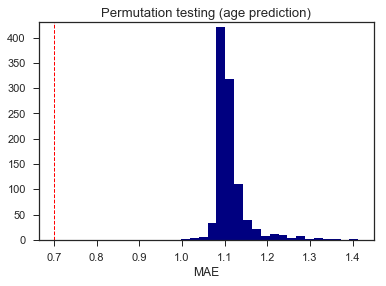

In [107]:
sns.set(font_scale=1.1)
sns.set_style('ticks')
plt.hist(perms_errs,bins=20, color='navy')
plt.xlabel('MAE')
plt.vlines(sorted_results[1][1][0],0,430,linewidth=1, color='r', linestyles='dashed' )
plt.ylim([0,430])
plt.title('Permutation testing (age prediction)')

Permutations L vs. R

In [276]:
parcels = pd.read_csv('parcels.txt',
                      sep='\t',header=None,names=['long','short','hemi'])
parcels = parcels.loc[wmgm_ids,:]
parcels.set_index(np.arange(81),inplace=True)

In [277]:
bstem_in_wmgm = np.where(wmgm_labels=='Brainstem, spans the midline')[0][0]

In [ ]:
nperms = 100
more_on_right = 0
matrices = build_matrices(wmgm_ids, fsubset(best_all_dc), ids, datapath+'final_parameters/')
left = np.zeros([nperms,1])
right = np.zeros([nperms,1])
for i in range(nperms):
    for j in range(bstem_in_wmgm-1):
        if j%2==0:
            if np.random.rand()>.5:
                matrices[:,[j, j+1],:] = matrices[:,[j+1, j],:]
                matrices[[j, j+1],:,:] = matrices[[j+1, j],:,:]
    for j in range(bstem_in_wmgm+1,80):
        if j%2==0:
            if np.random.rand()>.5:
                matrices[:,[j, j+1],:] = matrices[:,[j+1, j],:]
                matrices[[j, j+1],:,:] = matrices[[j+1, j],:,:]
    predictions, errors, folds, fscores, params, idx_filtered = predict_loo(matrices, 
            labels, model='elnet', doFilter=True, confounds=np.array((GA_all,gender)).T)
    end1,end2 = select_edges(len(wmgm_ids), fscores[:-2,:], 'elnet', th=.999)
    print (np.where(end1)[0].shape)
    for k in range(len(end1)):
        if end1[k] == bstem_in_wmgm:
            if parcels.iloc[end2[k],:]['hemi'] == 'l':
                left[i]=left[i]+1
            else:
                right[i]=right[i]+1
        elif end2[k] == bstem_in_wmgm:
            if parcels.iloc[end1[k],:]['hemi'] == 'l':
                left[i]=left[i]+1
            else:
                right[i]=right[i]+1
        else:
            if parcels.iloc[end1[k],:]['hemi'] == 'l' and parcels.iloc[end2[k],:]['hemi'] == 'l':
                left[i]=left[i]+1
            if parcels.iloc[end1[k],:]['hemi'] == 'r' and parcels.iloc[end2[k],:]['hemi'] == 'r':
                right[i]=right[i]+1
    if right[i]>left[i]:
        more_on_right = more_on_right+1
print(more_on_right/nperms)
pickle.dump({'right':right, 'left':left, 'more_on_right':more_on_right}, open('MSNs_age_LvsR.p','wb'))

In [316]:
np.where(right-left>5)[0].shape[0]/1000

0.036

In [288]:
end1,end2 = select_edges(len(wmgm_ids), results_msn[re.sub(',','',str(best_all_dc))][5][:-2,:], 'elnet', th=.999)
right = 0
left = 0
for k in range(len(end1)):
    if end1[k] == bstem_in_wmgm:
        if parcels.iloc[end2[k],:]['hemi'] == 'l':
            left=left+1
        else:
            right=right+1
    elif end2[k] == bstem_in_wmgm:
        if parcels.iloc[end1[k],:]['hemi'] == 'l':
            left=left+1
        else:
            right=right+1
    else:
        if parcels.iloc[end1[k],:]['hemi'] == 'l' and parcels.iloc[end2[k],:]['hemi'] == 'l':
            left=left+1
        if parcels.iloc[end1[k],:]['hemi'] == 'r' and parcels.iloc[end2[k],:]['hemi'] == 'r':
            right=right+1

In [289]:
right, left

(10, 5)

In [294]:
right_left_res = pickle.load(open('MSNs_age_LvsR.p','rb'))

In [291]:
np.where(right_left_res['right']-right_left_res['left']>=5)[0].shape

(0,)